## A (very) brief introduction to Color Doppler 

Color doppler is a medical imaging modality for blood flow imaging.  
It bases on the Doppler effect that is a shift of a received signal frequency, when the wave source is moving relatively to the receiver.  
In medicine, 'sources' (i.e. moving tissue, specifically blood) do not emit acoustic waves, but are 'iluminated' by ultrasound pulses produced by a probe.  
It can be shown [Evans2000] that the shift in the received frequency is given by following equation:

$$
f_d = f_t - f_r = \frac{2f_tv\cos{\alpha}}{c}
$$

where
* $f_d$ - frequency shift, or doppler frequency,
* $f_t$ - transmitted frequency, 
* $f_r$ - received frequency, 
* $v$ - speed of the blood,
* $\alpha$ - the angle between the ultrasound beam and the direction of motion of the blood,
* $c$ - speed of sound in the medium. It is usually assumed that in soft tissue $c = 1540 [m/s]$.

<!-- When the medical probe transmits the ultrasound pulse, and it is scattered on moving blood (i.e. on blood cells), the received echoes changes in phase.    -->
In classical approach the probe transmits a series of (quite long) ultrasound pulses, receiving echoes after each transmit.  
The series consists of $N$ transmit/receive (TR) events, and the higher $N$, the higher sensitivity, but lower doppler framerate.  
Typically $N$ could be in the range of $8-16$ for classical methods and $32-256$ for synthetic aperture methods, however there are no strict rules.  
The TR events in the series are repeated with constant Pulse Repetition Frequency (PRF).  
Thus the time between TR events - Pulse Repetition Interval (PRI) is equal $\frac{1}{PRF}$.  
The received signals are IQ demodulated and reconstructed into IQ images. 
These images correspond to successive time intervals, which is refered some times as a 'slow time', in oposition to the 'fast time', which is related to sampling.   
Then, the high-pass filter is applied to images (in 'slow time'). It is so-called wall clutter filter.
This filter is used for removing the constant echoes coming from non-flowing medium (like vessel walls and surrounding tissue).   


Note: IQ is a signal representation, where we have two signals 'in quadrature' i.e. the first (I) is in phase, and the second (Q) is shifted in phase by pi/2. 
Such representation is convenient in further signal processing.


## Estimators

The $f_d$ can be estimated from high-pass filtered IQ signal by means of autocorrelation esitmator:  

$$
\overline{f_d} = \frac{1}{2\pi{}PRI} 
    \tan^{-1}{\left\{ 
        \frac{\sum^{N}_{i=1}{Q(i)I(i-1) - I(i)Q(i-1)}}
             {\sum^{N}_{i=1}{I(i)I(i-1) + Q(i)Q(i-1)}}
    \right\}}
$$



<!-- , and next the phase is estimated for each sample.  
Then, for each sample the phase changes $\Delta{\theta}$ from TR to TR are calculated. Sometimes it is refered as phase changes in 'slow time'.  
The doppler frequency (averaged over time) can be calculated from the formula

$$
\overline{f_d} = \frac{1}{N-1} \sum_{n=1}^{N-1} \frac{\Delta{\theta}_{n}}{PRI}
$$

 -->
Then, we can use the following formula to estimate average speed of the blood flow.  

$$
v_s = \frac{\overline{f_d}}{f_t} \frac{c}{2\cos{\alpha}}
$$





The second mode used in medical flow imaging is power doppler, i.e. the power of the doppler signal.  
The power $p$ can be estimated using following estimator:

$$
p = \sum^{N}_{i=1}{I(i)I(i) + Q(i)Q(i)}
$$

The $p$ will be used to create a mask when displaying the flow - only those areas with adequate doppler signal strength will be displayed.

--------------------------------------------------------------------------------

## Let's implement above estimators in GPU kernel, use it, and show some doppler images.   

In this and the following notebooks, we will use the tools, tests and benchmarks available in the gpu_short_course Python package, which can be found in the repository https://github.com/us4useu/ius-2021-gpu-short-course. Please run the below line before proceeding:

In [1]:
! pip install --upgrade --force-reinstall -q git+https://github.com/us4useu/ius-2021-gpu-short-course@develop

### 'import' section

In [2]:
import cupy as cp
import numpy as np
import scipy.signal as spsig
import matplotlib.pyplot as plt
from IPython.display import HTML
from gpu_short_course.flow_imaging import (
    dB,
    filter_wall_clutter_gpu,
    iq2bmode_gpu,
    show_flow,    
    show_flow_cineloop,
)

GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'


In [3]:
# Cfg
plt.rcParams["animation.html"] = "jshtml"
plt.ioff()

### Kernel definition
The following kernel estimate both (non-scaled) doppler frequency (i.e. $\overline{f_d} \cdot{}2\pi{}PRI $) and the power $p$.  
Since similar data is used to estimate both, this is more optimal than creating two separate kernels.    
The kernel estimates doppler frames from IQ array.   
The IQ array is divided into batches (subsets) consisting of the same number of frames.   
Each doppler frame is estimated from a batch.   
The first frames in subsequent batches are separated by a fixed number of frames - 'step'. 
Thus, the batches can overlap.   

The kernel use following parameters:
* float *color - pointer to output array for color data,
* float *power - pointer to output array for power data,
* const complex\<float\> *iqFrames - pointer to input IQ array (I is in real part, Q is in imaginary part),
* const nBatch - number of batches
* const nBatchFrames - number of frames in single batch,
* const nx - number of columns in IQ data frame,
* const nz - number of samples in IQ data frame (it is common convention in the field to use 'z' axis for depth)
* const step - 'distance' (in [frames]) between the batches,


In [4]:
cuda_source = r"""

#include <cupy/complex.cuh>
extern "C" __global__ 
void doppler(float *color, 
             float *power, 
             const complex<float> *iqFrames, 
             const int nBatch, 
             const int nBatchFrames,             
             const int nx, 
             const int nz, 
             const int step)
                  
{
    int z = blockIdx.x * blockDim.x + threadIdx.x;
    int x = blockIdx.y * blockDim.y + threadIdx.y;
    int t = blockIdx.z * blockDim.z + threadIdx.z;
    
    if (z >= nz || x >= nx || t >= nBatch) {
        return;
    }
    
    /* Color and Power estimation */
        
    complex<float> iqCurrent, iqPrevious;
    float ic, qc, ip, qp, pwr, nom = 0.0f, den = 0.0f;

    iqCurrent = iqFrames[z + x*nz + t*nx*nz*step];
    ic = real(iqCurrent);
    qc = imag(iqCurrent);
    pwr = ic*ic + qc*qc;
    
    for (int iFrame = 1; iFrame < nBatchFrames; iFrame++) {
        // previous I and Q values
        ip = ic;
        qp = qc;
        
        // current I and Q values
        iqCurrent = iqFrames[z + x*nz + t*nx*nz*step + iFrame*nz*nx];
        ic = real(iqCurrent);
        qc = imag(iqCurrent);
        
        pwr += ic*ic + qc*qc;
        den += ic*ip + qc*qp;
        nom += qc*ip - ic*qp;
    }
    color[z + x*nz + t*nx*nz] = atan2f(nom, den);
    power[z + x*nz + t*nx*nz] = pwr/nBatchFrames;
}

"""
doppler = cp.RawKernel(cuda_source, 'doppler')


### Data loading

First, download example data.

In [5]:
! wget -c https://www.dropbox.com/s/hb5iuftzrz4vzd1/bmode.png -P ./data

--2021-08-19 11:46:58--  https://www.dropbox.com/s/hb5iuftzrz4vzd1/bmode.png
Translacja www.dropbox.com (www.dropbox.com)... 162.125.72.18, 2620:100:6027:18::a27d:4812
Łączenie się z www.dropbox.com (www.dropbox.com)|162.125.72.18|:443... połączono.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 301 Moved Permanently
Lokalizacja: /s/raw/hb5iuftzrz4vzd1/bmode.png [podążanie]
--2021-08-19 11:46:58--  https://www.dropbox.com/s/raw/hb5iuftzrz4vzd1/bmode.png
Ponowne użycie połączenia do www.dropbox.com:443.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 302 Found
Lokalizacja: https://uc6a07a7ffa337361187b8893c33.dl.dropboxusercontent.com/cd/0/inline/BUhtEaVm6kzqSNp17jd3olPon6oIniY4tcn0OEudEPCHn2JQIGoKqG-psyDSCNL7uLsY-n7vdYQruNSbhmBEsBvAeW0EfXX4W_0MNa0LrY8IPPE4H86WXOC64bYqGCVxxJ00JnN4WmhLOWc1Fc0PLaBS/file# [podążanie]
--2021-08-19 11:46:59--  https://uc6a07a7ffa337361187b8893c33.dl.dropboxusercontent.com/cd/0/inline/BUhtEaVm6kzqSNp17jd3olPon6oIniY4tcn0OEudEPCHn2JQIGoKqG-psyDSCNL7uLsY-n

In [6]:
! wget -c https://www.dropbox.com/s/2jf7mkd5kbkhzyx/example_doppler_data.npz -P ./data

--2021-08-19 11:46:59--  https://www.dropbox.com/s/2jf7mkd5kbkhzyx/example_doppler_data.npz
Translacja www.dropbox.com (www.dropbox.com)... 162.125.72.18, 2620:100:6027:18::a27d:4812
Łączenie się z www.dropbox.com (www.dropbox.com)|162.125.72.18|:443... połączono.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 301 Moved Permanently
Lokalizacja: /s/raw/2jf7mkd5kbkhzyx/example_doppler_data.npz [podążanie]
--2021-08-19 11:47:00--  https://www.dropbox.com/s/raw/2jf7mkd5kbkhzyx/example_doppler_data.npz
Ponowne użycie połączenia do www.dropbox.com:443.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 302 Found
Lokalizacja: https://uc1b510d891426c4105ae3e39e40.dl.dropboxusercontent.com/cd/0/inline/BUjN92BUp9kZrBiAtxiLDxfZFdyCcerEJDZWSnbAx4q3yFxhWshr_PJRuYZdLhVBwMsdZmO3kJ5GNVVK_ZfSSfBDP105cNGq0qEpMPX2ZcJKS1BXmFNEOQgqjR0kJWOjO3n0FLHyO6YIfb4ozQr-f9Qb/file# [podążanie]
--2021-08-19 11:47:00--  https://uc1b510d891426c4105ae3e39e40.dl.dropboxusercontent.com/cd/0/inline/BUjN92BUp9kZrBiAtxiLDxfZF

-----------------

These 512 IQ images were acquired from radial artery of healthy volunteer.  
The single plane wave imaging (PWI) scheme was used for each image.  
Transmit angle was 20 degree, and receive angle was equal 0 degree.   
The illustrative image below show the vessel as a darker region between 3-5 mm depth.    
The IQ data is organised in array of shape (n_frames, n_columns, n_samples).   
<!-- ![title](data/bmode.jpg) -->
<!-- <img src="data/bmode.png" width="500"> -->

![bmode](./data/bmode.png "B-mode")

In [7]:

data = np.load("data/example_doppler_data.npz")
iq = data["iq"] # frames of IQ data in array of (n_frames, n_columns, n_samples) shape
xgrid = data["xgrid"] # vector of 'x' coordinates
zgrid = data["zgrid"] # vector of 'z' coordinates
prf = data["prf"] # pulse repetition frequency
c = data["c"] # speed of sound
tx_frequency = data["tx_frequency"] # transmit frequency


### Color doppler estimation using defined kernel

In [8]:
# push iq data into gpu
iq_gpu = cp.array(iq)

In [9]:
# apply wall clutter filter
iq_wcfilt = filter_wall_clutter_gpu(iq_gpu, Wn=0.19, N=128, axis=0)

In [10]:
nframes, nx, nz = iq_wcfilt.shape

# set the number of frames in a batch, and step batches
nbatchframes = 256 
step = 8

# calculate number of batches 
nstep = np.floor((nframes - nbatchframes)/step).astype(int)
nbatch = nstep + 1

# specify block and grid sizes
bx = 16
bz = 16
bt = 4
gx = np.ceil(nx/bx).astype(int)
gz = np.ceil(nz/bx).astype(int)
gt = np.ceil(nbatch/bt).astype(int)
block = (bz, bx, bt)
grid = (gz, gx, gt)

# allocate memory on gpu for output data
color =  cp.zeros((nbatch, nx, nz)).astype(cp.float32)
power =  cp.zeros((nbatch, nx, nz)).astype(cp.float32)

# use kernel 
doppler(grid, block, (color, power, iq_wcfilt, nbatch, nbatchframes, nx, nz, step))

# transpose data to (samples, columns, frames) order, and get data from gpu 
color = color.T.get()
power = power.T.get()


### color scaling

In [11]:
# The transmit angle was 20deg, receive angle was 0deg - lets assume 10deg effective angle
alpha = 10/180*np.pi

# doppler frequency
fd = prf/2/np.pi*color # [Hz]

# blood speed
v = fd/tx_frequency*c/2/np.cos(alpha)


### Calculate B-mode data

In [12]:
# Make b-mode arrays from non-filtered iq data,  and get it from gpu.
# Each b-mode sub-array (bmode[:,:,i]) corresponds to data from the center of each batch.
bmode = np.zeros_like(color)
batch_center_frame = np.round(nbatchframes/2).astype(int)
for ibatch in range(nbatch):
    iframe = ibatch*step + batch_center_frame
    bmode[:,:,ibatch] = iq2bmode_gpu(iq_gpu[iframe,:,:]).T.get()


### Presentation of results 

#### show single image

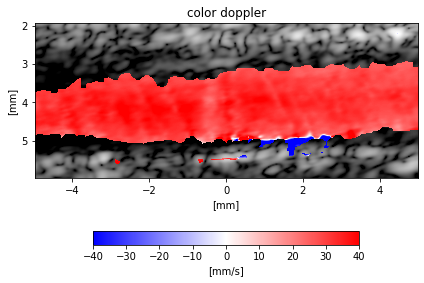

In [13]:
# make b-mode array from non-filtered iq data and get it from gpu
ibatch = 0
if ibatch > nbatch:
    raise ValueError(f"ibatch ({ibatch}) must be  less than or equal nbatch ({nbatch})")

# set parameters for show_flow() function
doppler_type = "speed"
# doppler_type = "power"
# doppler_type = "doppler frequency"
# doppler_type = "color"

bmode_limit = (-40, 0)
power_limit = (26, 56)
if doppler_type == "speed":
    cdata = v[:,:,ibatch] 
    
elif  doppler_type == "power":
    cdata = []

elif  doppler_type == "doppler frequency":
    cdata = fd[:,:,ibatch]

elif  doppler_type == "color":
    cdata = color[:,:,ibatch]

# final image
show_flow(
    bmode[:,:,ibatch], 
    cdata, 
    dB(power[:,:,ibatch]), 
    xgrid, zgrid,
    doppler_type=doppler_type,
    power_limit=power_limit,
    bmode_limit=bmode_limit)

plt.show()


#### show animation

In [35]:
# doppler_type = "speed"
doppler_type = "power"
# doppler_type = "doppler frequency"
# doppler_type = "color"

bmode_limit = (-40, 0)
power_limit = (26, 56)
if doppler_type == "speed":
    cdata = v
    
elif  doppler_type == "power":
    cdata = []

elif  doppler_type == "doppler frequency":
    cdata = fd

elif  doppler_type == "color":
    cdata = color

anim = show_flow_cineloop(
    bmode, 
    cdata, 
    dB(power),
    xgrid=xgrid,
    zgrid=zgrid,
    doppler_type=doppler_type,
    power_limit=power_limit,
    bmode_limit=bmode_limit)

HTML(anim.to_jshtml())


## Performance considerations

The third part of this course (notebook 3_Performance_guidelines.ipynb) deals with the influence of memory organization on the kernel performance and we encourage you to read its content.   
As shown there, memory organization can have a great influence on performance, and it is generally good if the data the kernel is running on is close together in memory.   
Let's see if we can speed up the filtration of wall clutter by reorganizing the input data.   
First, we use the same approach as before, and measure time 8 times, to make some small statistics.  Note the use of cp.cuda.Stream.null.synchronize() - it is to assure, that all kernels finish their work each time the cell is called. 

In [33]:
%%timeit -n 8
iq_wcfilt = filter_wall_clutter_gpu(iq_gpu, Wn=0.19, N=128, axis=0)
cp.cuda.Stream.null.synchronize()


166 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 8 loops each)


Now, lets check the iq_gpu array data organization in the memory:

In [16]:
iq_gpu.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True

The first line (C_CONTIGUOUS : True) means, that the data is in row-major order. When filter acts along the first dimension (axis=0) the data it working on are not close together, so it is probably not optimal. Therefore, we could transpose data, filter it and then return to the previous data organization by tranpose filtered data once more.   

Now, we try to use filter on the transposed data. Note, that by using cp.ascontiguousarray(iq_gpu.T) command, the array is rewritten in the correct order, not just reordering dimensions in ndarray.

In [34]:
%%timeit -n 8
iq_wcfilt = filter_wall_clutter_gpu(
    cp.ascontiguousarray(iq_gpu.T), 
    Wn=0.19, 
    N=128, 
    axis=-1
).T
cp.cuda.Stream.null.synchronize()


202 ms ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 8 loops each)


This time there were more operations to perform (2x array transposition), but the memory organization was better. Is the performance is better?

-----------------------------------------

## References

[Evans2000] Evans, David H., and W. Norman McDicken. Doppler ultrasound: physics, instrumentation and signal processing. Wiley-Blackwell, 2000.